# Data Science and Visualization (RUC F2023)

## Miniproject Report

## Project Title: Energy consumption of algorithms and evaluation of data

## Group Members:
* [Mathias, computer science and informatics, 3rd year, mamaar@ruc.dk]
* [Martin, computer science and informatics, 3rd year, sundman@ruc.dk]


## Abstract

[Here, you need to write ~5 sentences to describe the main points of your project, including but not limited to, dataset, research questions, data science methods, findings from the data, your condlusions and remarks.]

The dataset is the result of an experiment measuring energy consumption of sorting algorithms. 
We are investigating how time complexity affects energy consumption of algorithms. 
We model the data using polynomial regression calculating the $R^2$ value to find the best fit.
Findings
Conclusion


## 0. Setup and Data

Import the modules needed for the project.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# QUESTIONS

-   what is feature selection (section 4.1)
-   how do we get the function describing the polynomial gotten from the regression (section 4.1)
-   memeory doesnt work (section 1)


### Data description:

[Here you should provide a description of your dataset and where to find the dataset.]
The data loaded in the next cell is data gathered by our bachelor project group. In this project we are investigating energy consumption of algorithms run on specific laptops. The data is gathered with a tool supported by Intel processers called 'Running Average Power Limit' (RAPL). To understand full where the energy consumption comes from the resulting CSV containging the data will have these columns: 

RAPLCSV = [Test Name, PKG (J), CPU (J), GPU (J), Memory (J),Temperature (&deg;C), Time (ms)]


Further more, the memory consumption of the algorithmic run is extracted to a different CSV, due to impracticalities in the test repository on git: https://github.com/hrallil/RAPL_measurements

Memory = [Memory (byte)]

These two will be bound into one dataFrame with columns: 

df = ``[Test Name, PKG (J), CPU (J), GPU (J), Memory (J),Temperature (``&deg;``C), Time (ms), Memory (byte), Size]``

#### Column desctiption:
-    `Test Name` is the name of a sample and is use as an identifyer/key for that sample. 
-    ``PKG (J)`` contains the total power consumption of the socket.
-    ``CPU (J)`` Contains the power consumption of the CPU cores of the socket.
-    ``GPU (J)`` Contains the power consumption of the integrated graphics accociated with the socket. IS NOT USED since the test laptops do not have GPU's.
-    ``Memory (J)`` contains the power consumption of the memory controller in the socket.
-    ``Temperature (``&deg;``C)`` contains the temperature of the socket.
-    ``Time (ms)`` contains the walltime of this sample.
-    ``Memory (byte)`` contains memory consumption of this sample.
-    ``Size`` contains the Size of the input array for the specific sample.



## 1. Loading the Data

In [ ]:
df = pd.read_csv("data/mergeSort-PC16.csv") 
df.columns=["Test name","PKG (J)","CPU (J)","GPU (J)","Memory (J)","Temperature","Time (ms)"]
l = []
dfMemory = pd.DataFrame(l.append(i) for i in range(11600))
dfMemory = pd.read_csv("data/MergeSortMemory-PC16.csv") #What in the fuck 15249696.1 ? 


dfMemory = dfMemory.transpose()

dfMemory["Memory (byte)"] = dfMemory.index

dfMemory = dfMemory.reset_index()
l = []
for i in range(len(dfMemory["Memory (byte)"])):
    l.append(int(float(dfMemory["Memory (byte)"][i])))

l
df["Memory (byte)"] = l


df


,Test name,PKG (J),CPU (J),GPU (J),Memory (J),Temperature,Time (ms),Memory (byte)
0,random1-25000-1,2.086792,1.796448,,0.131958,38,247.946,3393216
1,random1-25000-1,2.237671,1.952087,,0.138672,38,234.279,3391896
2,random1-25000-1,2.227417,1.941711,,0.142029,38,237.194,3397320
3,random1-25000-1,2.227234,1.935608,,0.140259,38,232.236,3385072
4,random1-25000-1,2.076599,1.804749,,0.129883,38,227.670,3396008
...,...,...,...,...,...,...,...,...
18794,random10-1000000-1,8.915527,7.729553,,0.477112,68,1024.890,142964344
18795,random10-1000000-1,9.108032,7.892151,,0.495239,68,1035.310,142429824
18796,random10-1000000-1,8.649841,7.518066,,0.475403,67,962.433,19941920
18797,random10-1000000-1,8.933716,7.770569,,0.468750,67,1000.870,17307600


## 2. Data Preprocessing

In this section, the data will show the missing data as NaN and will output how much missing data we have. 
Further more, this section will also consider if the values in the dataset are nonense, for instance if the energy consumption of one sample is below 0, we consider it nonsense and an error point made during reading. 

Finally, the data will also have the final column appended, ``Size``. This column is extracted from the column ``Test name``

In [ ]:
#removing values that are nonsense 
df = df[df['PKG (J)'] >= 0]
df = df[df['CPU (J)'] >= 0]
#df = df[df['Memory (byte)'] >= 0.0]
df = df[df['Temperature'] >= 0.0]
df = df[df['Time (ms)'] >= 0.0]

df = df.replace("  ", np.nan)

#missing values for each column
print("MISSING DATA: \n\n ", df.isnull().sum(axis=0))

l = []
for i in range(len(df)):
    l.append(int(df.iloc[i]["Test name"].split("-")[1]))

df["Size"] = l

MISSING DATA: 

  Test name            0
PKG (J)              0
CPU (J)              0
GPU (J)          18799
Memory (J)           0
Temperature          0
Time (ms)            0
Memory (byte)        0
dtype: int64


Since the laptops do not contain a GPU, we expect missing data on GPU(j). 
Now that the data has been checked for missing data, we want to seperate the data into different sub-datasets. 

These sets will contain samples from each input type, which includes Best case input, worst case input and random input. 

Further more, random input has 10 different randoms to ensure that the one random that the system was tested on was not just a "lucky random".

In [ ]:
#random input seperated into a list, where each element is a DataFrame containing that random CSVs output
listOfRandoms = []
for randIndex in range(0,11):
    listOfRandoms.append(df[df["Test name"].str.startswith(f"random{randIndex}-")])


# Dataframe containing results for the best case input 
dfBest = df[df["Test name"].str.startswith("best")]
# Dataframe containing results for the worst case input 
dfWorst = df[df["Test name"].str.startswith("worst")]

## 3. Exploratory Data Analysis

[Below you can conduct EDA of your data, e.g., ask some questions and try to answer them by accessing the data properly and making some visualizations.]

First we some graphs showing the data of energy consumption by index 


Plot (time, size), (temp, time), (CPU(J),size) for each input case.

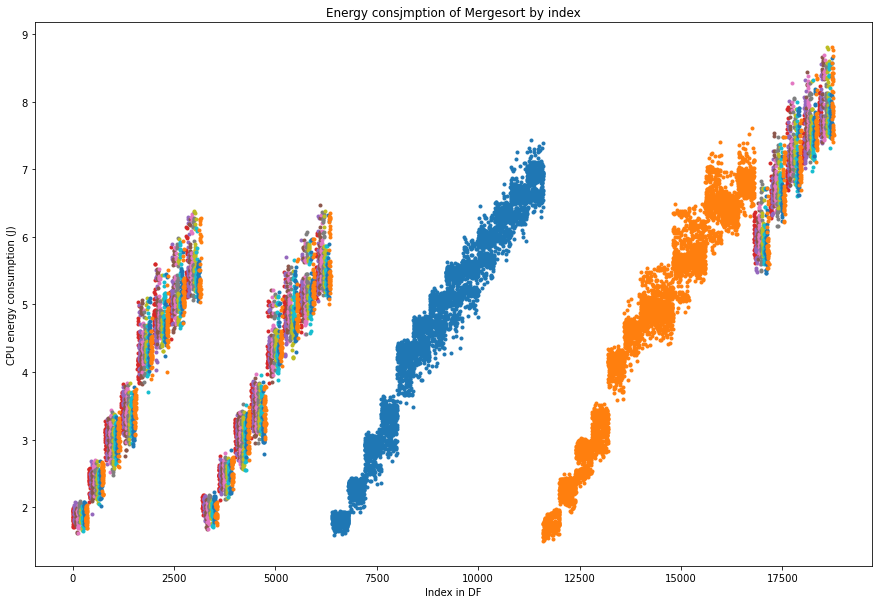

In [ ]:

#energy consumption
plt.figure(figsize=(15,10))
plt.plot(dfBest["CPU (J)"], ".")
plt.plot(dfWorst["CPU (J)"],".")
for i in range(10):
    plt.plot(listOfRandoms[i]["CPU (J)"],".")
plt.title("Energy consjmption of Mergesort by index")
plt.xlabel("Index in DF")
plt.ylabel("CPU energy consumption (J)")
plt.show()

Since this shows us very little, we further seperate data by size, and consider size as x-axis. Although since size is a very descrete value, we see on the graph below that the data is almost placed in columns.
Each column representing a test size, and each dot in each column being a sample of that size. Here, each color represents a different test case: best (green), worst (red), random (orange). This shows the energy consumption rise as the input size rises. 

This can be done to show the rise of time consumption, memory consumption and temperature aswell. 

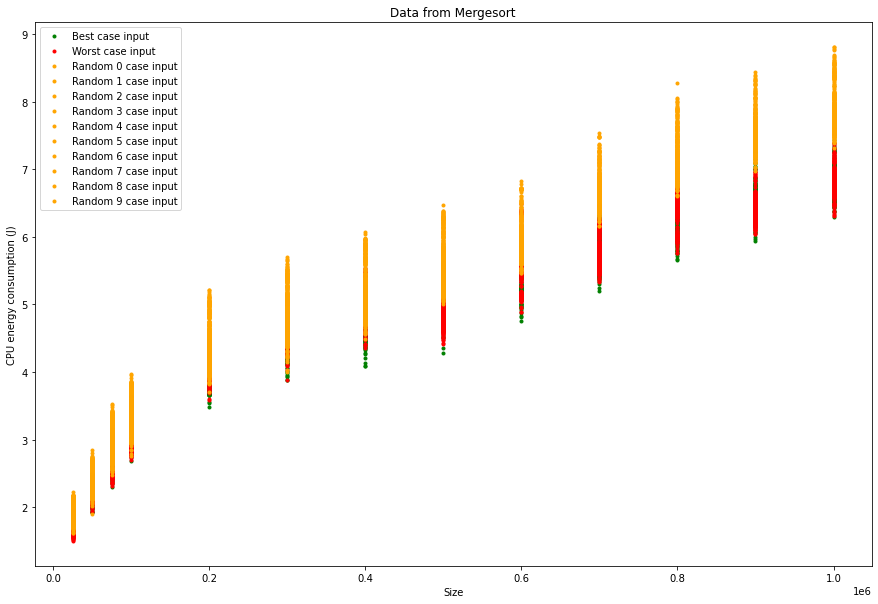

In [ ]:
#energy vs size
plt.figure(figsize=(15,10))
plt.plot(dfBest["Size"], dfBest["CPU (J)"], ".",color = "green", label = "Best case input")
plt.plot(dfWorst["Size"], dfWorst["CPU (J)"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"],".", color = "orange", label = f"Random {i} case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("CPU energy consumption (J)")
plt.legend()
plt.show()

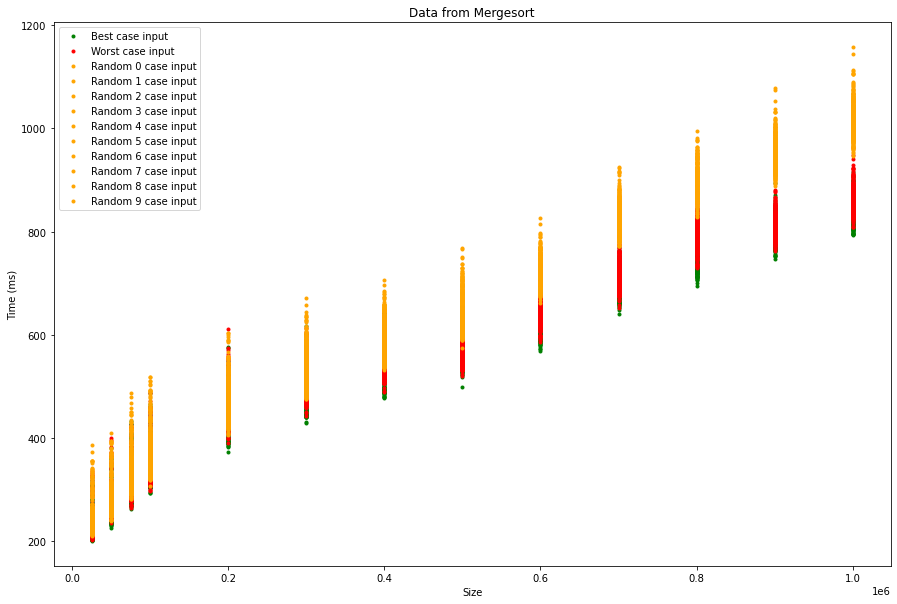

In [365]:
#Time vs size
plt.figure(figsize=(15,10))
plt.plot(dfBest["Size"], dfBest["Time (ms)"], ".",color = "green", label = "Best case input")
plt.plot(dfWorst["Size"], dfWorst["Time (ms)"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"],".", color = "orange", label = f"Random {i} case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("Time (ms)")
plt.legend()
plt.show()

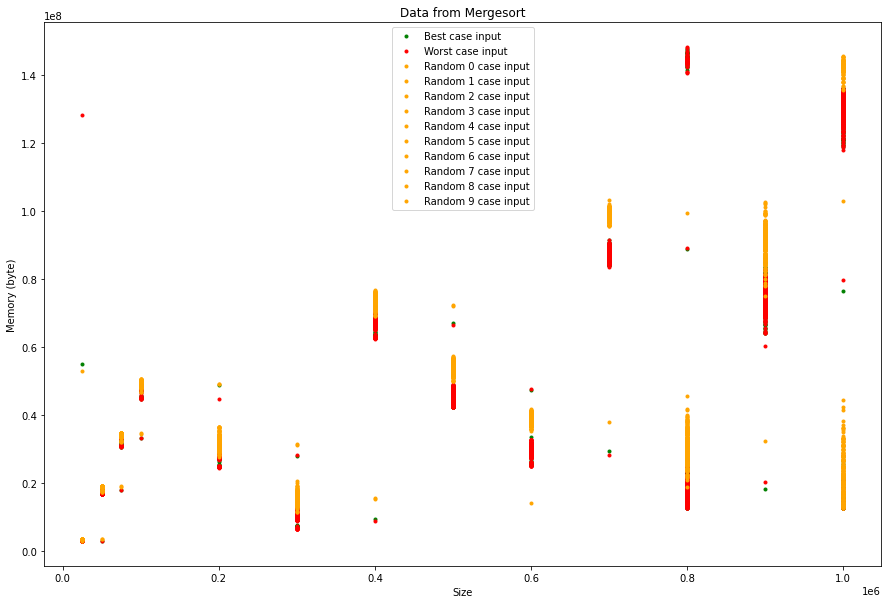

In [366]:
#Memory consumption vs size
plt.figure(figsize=(15,10))
plt.plot(dfBest["Size"], dfBest["Memory (byte)"], ".",color = "green", label = "Best case input")
plt.plot(dfWorst["Size"], dfWorst["Memory (byte)"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["Memory (byte)"],".", color = "orange", label = f"Random {i} case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("Memory (byte)")
plt.legend()
plt.show()

##### Comment for Memory (byte) vs size
For the case of Memory consumption vs size, the test setup must be considered when evaluating the graph above. The mergesort which the measurements were gotten from has been implimented in Java, which has a garbage collector and a JIT which both ensure that memory does not overflow. These two might be the reason for the rather arbitrary look of the memory vs size graph above

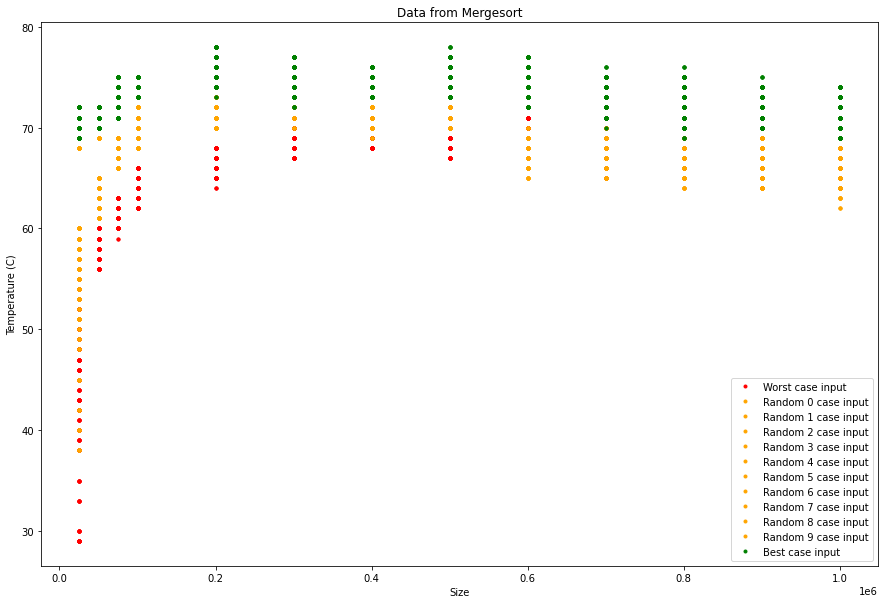

In [367]:
#Temp vs size
plt.figure(figsize=(15,10))
plt.plot(dfWorst["Size"], dfWorst["Temperature"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["Temperature"],".", color = "orange", label = f"Random {i} case input")
plt.plot(dfBest["Size"], dfBest["Temperature"], ".",color = "green", label = "Best case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

##### Comment for temperature vs size
In the case for the temperature vs size, The data seems to indicate that a  best case input for a small size will make the pc run at a high temperature, although this is not correct. This discrepancy is due to the best being run after the random measurement, making the starting temperature higher for best aswell.  

### Normal distribution
For each of the three cases (best, worst, Random) we consider if the sample groups on each size is normal distributed. Here we use the Shapiro wilk method from scipy.stats

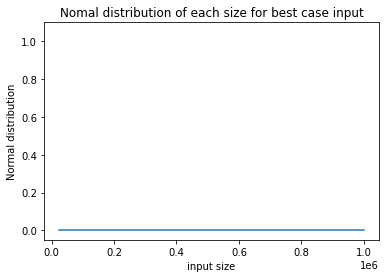

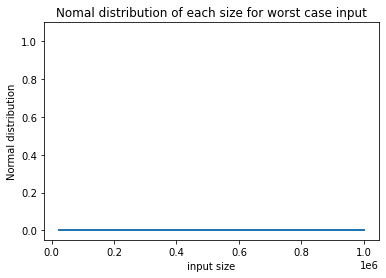

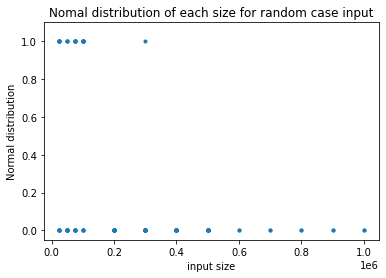

(array([44., 11., 11., 11., 11.,  2.,  2.,  2.,  2.,  2.]),
 array([  25000.,  122500.,  220000.,  317500.,  415000.,  512500.,
         610000.,  707500.,  805000.,  902500., 1000000.]),
 <BarContainer object of 10 artists>)

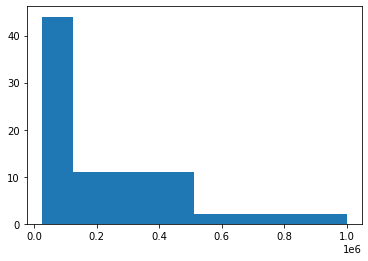

In [368]:
from scipy.stats import shapiro

data = []
size = []

for i in [25000,50000,75000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]:
    #print(f"Size {i}, normal distributed:                           {0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue}")
    if 0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue:
        data.append(1)
    else:
        data.append(0)
    size.append(i)
    #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
    #plt.show()

plt.plot(size,data)
plt.xlabel("input size")
plt.ylabel("Normal distribution")
plt.title("Nomal distribution of each size for best case input")
plt.ylim(-.05,1.10)
plt.show()

#print("worst case input")
for i in [25000,50000,75000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]:
    #print(f"Size {i}, normal distributed:                           {0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue}")
    if 0.05 < shapiro(dfWorst[dfWorst['Size'] == i]['CPU (J)']).pvalue:
        data.append(1)
    else:
        data.append(0)
    size.append(i)
    #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
    #plt.show()

plt.plot(size,data)
plt.xlabel("input size")
plt.ylabel("Normal distribution")
plt.title("Nomal distribution of each size for worst case input")
plt.ylim(-.05,1.10)
plt.show()

for i in [25000,50000,75000,100000,200000,300000,400000,500000]:
    for j in range(1,10):
        #print(f"random{j} Size {i}, normal distributed:                     {0.05 < shapiro(listOfRandoms[j][listOfRandoms[j]['Size'] == i]['CPU (J)']).pvalue}")
        #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
        #plt.show()
        
        if 0.05 < shapiro(listOfRandoms[j][listOfRandoms[j]['Size'] == i]['CPU (J)']).pvalue:
            data.append(1)
        else:
            data.append(0)
        size.append(i)
        #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
        #plt.show()

plt.plot(size,data, ".")
plt.xlabel("input size")
plt.ylabel("Normal distribution")
plt.title("Nomal distribution of each size for random case input")
plt.ylim(-.05,1.10)
plt.show()

plt.hist(size, )



According to the shapiro test if the returning pValue > 0.05 then the data is normal distrubuted and oppositely if pValue is < 0.05 then the data is not normal distributed. 

here we see that the data is not normal distributed for best case, worst case data is missing ATM, and the larger the input size was, the less fequent normal distributed data occured.

## 4. Data Modelling

In this section, we will be applying some models to the data, in order to evaluate the data against one another. Here we consider that the data is of growth over time, or in our case size. This makes our data continous, and therefor we chose to apply models of type regression. Here there are 4 different types to evaluate, Linear regression, polunomial regression, Logistic regression and Decision Tree regressor. Once each type of regression is implimented, they are evaluated through their $R^2$ value.


### 4.1. Feature Selection

To compare energy, time and memory consumption of algorithms to eachother, we make a polynomial regression. 
When making a polynomial regression it is important to evaluate which degree the polynomial is at.

This can be done with metrics.r2_score(y, y_poly) on each degree. This will return a fitness value, in the form of a procentage represented as a float. Where 1.00 is 100% accuracy  


#### Structure of 4:
-   Best Time vs Size 
-   Worst Time vs Size
-   Random Time vs Size
    - Description of best degree for time
-   Best CPU energy consumption vs Size
-   Worst CPU energy consumption vs Size
-   Random CPU energy consumption vs Size
    - Description of best degree for CPU energy consumption


#### structure of 4
-   4.1 choose which parameters we use for the multiple 'models'
-   4.2 create loads of models (Poly, Liniear, DTR, Logit) and evaluate {R^2}
-   4.3 apply the model with the highest r2 value from 4.2 and use "extensive evaluation" to further judge if the model fits (what ever that means) 
-   4.4 plot the model


All paramaters except GPU (J) of the data will be evaluated. PKG (J) is a measure of system energy use while CPU (J) and memory (J) are more specific. Time (ms) is connected to CPU (J) and memory (bytes) is connected to memory (J). Temperature is relavant for all energy measurements. Test name and size seperates the data accordingly.
Once evaluated we can compare and discuss corralation.

All paramaters except GPU (J) of the data will be evaluated. PKG (J) is a measure of system energy use while CPU (J) and memory (J) are more specific. Time (ms) is connected to CPU (J) and memory (bytes) is connected to memory (J). Temperature is relavant for all energy measurements. Test name and size seperates the data accordingly.
Once evaluated we can compare and discuss corralation.

### 4.2 Model Construction and Validation

[Construct the model and validate the model design if necessary.]

### Polynomial Regression ###

In [369]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from operator import itemgetter

def polyReg(SeriesX, SeriesY,maxDegrees, Label, color, minDegrees = 2, plotLabel = True, printR2Score = True, plotGraph = True):
    X = SeriesX.values.reshape(SeriesX.size, -1)
    y = SeriesY.values

    colors = ["white","black","purple",color , 'cyan', 'yellowgreen', 'gold', color,'green','violet']

    fitness = []
    for dg in range(minDegrees, maxDegrees):
        # Create an empty polynomial function with degree of 4
        poly_reg = PolynomialFeatures(degree=dg)
        
        # Fit the function to the X and transform X to the polynomial format
        X_poly = poly_reg.fit_transform(X)

        # Now we construct a Multiple Linear Regressor on the transformed X_ploy
        lr_2 = LinearRegression()  
        lr_2.fit(X_poly, y)  
        
        # Get the y values using the constructed Multiple Linear Regressor
        y_poly = lr_2.predict(X_poly)
        
        r2 = metrics.r2_score(y,y_poly)
        #if printR2Score:
        #    print(f"r2_score for {Label} {dg} is: {r2}")
        fitness.append((f"poly {dg}dg", r2, y_poly))
        #print(f"Parameters of poly: {poly_reg.get_params()}") #does not give what we are looking for
    
    if plotGraph:
        plt.scatter(X, y, color=color, label=Label)
        plt.legend(loc='upper left')
        plt.plot(X, y_poly, color=color,label= Label, linewidth=2)
    return max(fitness,key=itemgetter(1))
        


### Linear Regression ###

In [370]:
import statsmodels.formula.api as smf

def linReg(SeriesX, SeriesY, Label, color, minDegrees = 1, plotLabel = True, printR2Score = True, plotGraph = True ):
    return polyReg(SeriesX, SeriesY, 2, Label, color, minDegrees=minDegrees, plotLabel=plotLabel, printR2Score=printR2Score, plotGraph=plotGraph)

### DTR ###

In [371]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor    # Import decision tree regression model


def dtr(SeriesX, SeriesY, Label, color, plotLabel = True, printR2Score = True, plotGraph = True, strX='Size'):
    # Sort X and y by ascending values of X
    SeriesX = SeriesX.sort_values(by=[strX])
    #return y_train, X_train.index
    SeriesY = SeriesY[SeriesX.index]

    # Initialize and fit regressor
    dtRegressor = DecisionTreeRegressor(criterion='squared_error', max_depth=3)         
    dtRegressor.fit(SeriesX, SeriesY)

    y_pred = dtRegressor.predict(SeriesX)
    #y_plot = plt.plot(X, y_pred, color=color,label= Label, linewidth=2)
    if plotGraph:
        # Plot actual target against the feature
        plt.scatter(SeriesX, SeriesY, c=color, edgecolor='white', s=70)

        # Plot predicted target against the feature (Decision tree regression)
        plt.plot(SeriesX[strX].values, dtRegressor.predict(SeriesX), color=color, lw=2, label=Label)

    return ("DTR",metrics.r2_score(SeriesY,y_pred), y_pred)

#### Logistic regression

This regression technique is not implimented. This is due to the nature of the logistic regression. This regression method will create a logistic regression spaning over binary data. This can be very useful for estimating dianosis in medicin, but since the data gathered in this project is not binary, we omit the use of Logistic regression.

In [372]:
#plt.figure(figsize=(15, 10))
def bestReg(df, name, column):
    pfit = polyReg(df["Size"], df[column], 10, "Best", "red", plotGraph=False)
    lfit = linReg(df["Size"], df[column], "Best", "blue", plotGraph=False)
    dfit  = dtr(df[["Size"]], df[column], "Best DTR", "green", plotGraph=False)
    best = max([pfit, lfit, dfit],key=itemgetter(1))
    print(f"Best regression for {name} on {column} is {best[0]} with R2 value = {best[1]}")
    

In [373]:

bestReg(dfBest, "best case","Time (ms)")
bestReg(dfWorst, "worst case","Time (ms)")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","Time (ms)")

print("\n")

bestReg(dfBest, "best case","CPU (J)")
bestReg(dfWorst, "worst case", "CPU (J)")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","CPU (J)")
    
print("\n")

bestReg(dfBest, "best case", "Memory (byte)")
bestReg(dfWorst, "worst case", "Memory (byte)")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","Memory (byte)")

print("\n")

bestReg(dfBest, "best case","Temperature")
bestReg(dfWorst, "worst case", "Temperature")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","Temperature")

Best regression for best case on Time (ms) is poly 3dg with R2 value = 0.9755994047348076
Best regression for worst case on Time (ms) is DTR with R2 value = 0.9753314663216558
Best regression for random 1 on Time (ms) is DTR with R2 value = 0.976155751094254
Best regression for random 2 on Time (ms) is DTR with R2 value = 0.9748427304867167
Best regression for random 3 on Time (ms) is DTR with R2 value = 0.9778094470089691
Best regression for random 4 on Time (ms) is DTR with R2 value = 0.9758647211669461
Best regression for random 5 on Time (ms) is poly 3dg with R2 value = 0.9770826977426703
Best regression for random 6 on Time (ms) is poly 3dg with R2 value = 0.9779752983739736
Best regression for random 7 on Time (ms) is poly 3dg with R2 value = 0.9751357975247555
Best regression for random 8 on Time (ms) is DTR with R2 value = 0.9750156300035938
Best regression for random 9 on Time (ms) is poly 3dg with R2 value = 0.9768191301295461
Best regression for random 10 on Time (ms) is pol

Since the best r2_score for the Best case input is 0.980542818732591 which is greater than the others. 

That means that Degree 3 polynomial is the best fit for the data for best case input.

### 4.3 Model Application and Performance Evaluation

[Apply the model and evaluate its performance] {SPLIT DATASET INTO TRAINING(80%) AND VALIDATION(20%) AND DO SOME ML VALIDATION}

In [374]:

def validateModel(SeriesX, SeriesY, reg, label):
    X_train, X_test, y_train, y_test = train_test_split(SeriesX, SeriesY, test_size = 0.20)
    
    if reg == 'poly':
        #model = polyReg(X_train,y_train,4,"poly","red",3, plotGraph=False)[2]
        X_train = X_train.values.reshape(X_train.size, -1)
        X_test = X_test.values.reshape(X_test.size,-1)
        y_train = y_train.values

        poly_reg = PolynomialFeatures(degree=3)
        
        # Fit the function to the X and transform X to the polynomial format
        X_poly = poly_reg.fit_transform(X_train)
        x_test_poly = poly_reg.fit_transform(X_test)

        # Now we construct a Multiple Linear Regressor on the transformed X_ploy
        lr_2 = LinearRegression()  
        lr_2.fit(X_poly, y_train)  
        
        # Get the y values using the constructed Multiple Linear Regressor
        model = lr_2.predict(x_test_poly)
        

    if reg == 'dtr':
        #model = dtr(X_train,y_train, "dtr", "red", plotGraph=False)[2]

        dtRegressor = DecisionTreeRegressor(criterion='squared_error', max_depth=3)         
        dtRegressor.fit(X_train, y_train)

        model = dtRegressor.predict(X_test)
    
    print(f'{label} {reg} Mean Absolute Error:', metrics.mean_absolute_error(y_test, model))
    print(f'{label} {reg} Mean Squared Error:', metrics.mean_squared_error(y_test, model))
    print(f'{label} {reg} Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model)))

In [388]:

validateModel(dfBest["Size"], dfBest["Time (ms)"], "poly","Best")
print("\n")
validateModel(dfWorst["Size"], dfWorst["Time (ms)"], "poly","Worst")
print("\n")
for i in range(1,len(listOfRandoms)):
    validateModel(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"],"poly","Random "+str(i))
    print("\n")
print("\n")


validateModel(dfBest["Size"], dfBest["CPU (J)"], "poly","Best")
print("\n")
validateModel(dfWorst["Size"], dfWorst["CPU (J)"], "poly","Worst")
print("\n")
for i in range(1,len(listOfRandoms)):
    validateModel(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"],"poly","Random "+str(i))
    print("\n")
print("\n")

validateModel(dfBest[["Size"]], dfBest["Memory (byte)"], "dtr","Best")
print("\n")
validateModel(dfWorst[["Size"]], dfWorst["Memory (byte)"], "dtr","Worst")
print("\n")
for i in range(1,len(listOfRandoms)):
    validateModel(listOfRandoms[i][["Size"]], listOfRandoms[i]["Memory (byte)"],"dtr","Random "+str(i))
    print("\n")
print("\n")

validateModel(dfBest[["Size"]], dfBest["Temperature"], "dtr","Best")
print("\n")
validateModel(dfWorst[["Size"]], dfWorst["Temperature"], "dtr","Worst")
print("\n")
for i in range(1,len(listOfRandoms)):
    validateModel(listOfRandoms[i][["Size"]], listOfRandoms[i]["Temperature"],"dtr","Random "+str(i))
    print("\n")
print("\n")

Best dtr Mean Absolute Error: 0.8759890868679955
Best dtr Mean Squared Error: 1.2838865956202634
Best dtr Root Mean Squared Error: 1.1330871968300866


Worst dtr Mean Absolute Error: 1.3659245076700772
Worst dtr Mean Squared Error: 4.340672656188779
Worst dtr Root Mean Squared Error: 2.08342810199651


Random 1 dtr Mean Absolute Error: 2.946092036599868
Random 1 dtr Mean Squared Error: 22.905080880996156
Random 1 dtr Root Mean Squared Error: 4.785925289951376


Random 2 dtr Mean Absolute Error: 1.911700916288515
Random 2 dtr Mean Squared Error: 9.407384771232282
Random 2 dtr Root Mean Squared Error: 3.0671460303077


Random 3 dtr Mean Absolute Error: 1.7961489257450032
Random 3 dtr Mean Squared Error: 6.767855823695721
Random 3 dtr Root Mean Squared Error: 2.6015102966730157


Random 4 dtr Mean Absolute Error: 2.093233320881253
Random 4 dtr Mean Squared Error: 7.942132940889401
Random 4 dtr Root Mean Squared Error: 2.818179011505373


Random 5 dtr Mean Absolute Error: 1.600118397436981



##### Mean Absolute Error
|Name | Time| CPU| Memory | Temp |
|-|-|-|-|-|
| Best | 25.002523358507112 |0.21777125261032024 |14002162.38044693 |0.8759890868679955 |
| Worst | 27.415913137453902 | 0.23630725440377962 | 14889959.267985439| 1.3659245076700772 |
| Random1 | 26.965630997829823| 0.2875593530578422 |  9515387.870960256|2.946092036599868 |
|Random2 | 31.14562064500721 |0.2815347400069377 |11112934.40305218 |1.911700916288515 |
|Random3 | 28.616387789809714| 0.29348453344822145 | 11514100.60042033|1.7961489257450032 |
|Random4 | 29.189290592232013 |0.28496063925109877 |9466840.018541757 | 2.093233320881253 |
|Random5 | 27.705380907052835 | 0.27407128722402085 |8595524.304917129 |1.6001183974369813 |
|Random6 | 25.74863700013513 |0.2704589191484651 |9618442.310524937 | 1.708179743566284 |
|Random7 | 28.72903828703334 |0.2724599538195044 | 9335294.968603654| 1.8797639927241163 |
|Random8 | 29.060342836645706 |0.27283962817002666 |9977819.793777673 |1.6151042090422616 |
|Random9 | 30.5800848797481 | 0.2801512767303244| 8392087.22243133| 1.636446283185413|
|Random10 | 26.902357714534954 | 0.27989020501768846 |11333384.631363403 |1.7603960003333836 |

##### Mean Squared Error
|Name | Time| CPU| Memory | Temp |
|-|-|-|-|-|
| Best | 955.1091300861767 | 0.06975370826079137 | 411817167518846.75|1.2838865956202634 |
| Worst | 1205.5866727672096 | 0.09196996095019636 |453903767414597.2 |4.340672656188779 |
| Random1 | 1197.6208433379975 |0.09262051416828104 | 358015604350260.9|22.905080880996156 |
|Random2 | 1406.0192018422701 | 0.1238187979493681 | 376849188160009.25| 9.407384771232282 |
|Random3 | 1218.3379897428754 |0.11084184800075533 |387770074571717.1 | 6.767855823695721|
|Random4 | 1391.7197888157295 |0.11801419194111401 |260537603095458.47 | 7.942132940889401|
|Random5 | 1301.2559205883558 |0.11257799733497757 |201970973009096.8 | 4.363051868819932|
|Random6 | 1154.4348127300325 |0.09975927308934758 |263076399354128.56 | 4.747380404781869|
|Random7 | 1237.739554819195 |0.11036462547762958 |248008827242522.47 | 5.77984322897397 |
|Random8 | 1353.977572720779 |0.09403054531319491 |  325702213305533.7 |3.953386574914049 |
|Random9 | 1511.2978616471137 |  0.12754126067493476|184775913951118.88 |4.545753874642388 |
|Random10 | 1151.6538187535818 |  0.1111278594067314|369851710791782.9 | 4.68502959837641|

##### Root Mean Squared Error
|Name | Time| CPU| Memory | Temp |
|-|-|-|-|-|
| Best |30.904839913615096 | 0.2641092733335794|20293278.875500795 | 1.1330871968300866 |
| Worst |34.72155919262857 | 0.30326549581216183 | 21305017.42347556| 2.08342810199651|
| Random1 | 34.606658945035385 |0.3043361860973503 | 18921300.28170001|4.785925289951376 |
|Random2 |37.49692256495552 |0.3518789535470516 |19412603.848016094 |3.0671460303077 |
|Random3 |34.90469867715341 |0.3329291936745039 |19691878.391146872 |2.6015102966730157
 |
|Random4 |37.305760799315294 | 0.34353193729421144|16141177.252463913 |2.818179011505373 |
|Random5 |36.072925035105705 |0.3355264480409519 | 14211649.20088787 |2.088791963987781 |
|Random6 |33.97697474364121 |0.3158469140095366 |16219630.06218479 |2.178848412529396 |
|Random7 |35.18152291784986 |0.3322117178511763 | 15748296.0107601|2.404130451738002 |
|Random8 |36.79643423921371 |0.3066440042022588 | 18047221.76141064|1.9883124942810295 |
|Random9 |38.875414617044456 | 0.3571291932549547|13593230.445744634 | 2.1320773613174517
|
|Random10 |33.93602538238062| 0.3333584548301294 |19231529.08095929 |2.164492919456289 |




### 4.4 Visualize and Analyze Your Results/Findings from Data Modelling

In this section we will fist plot each graph individually, including their models, ie. (Size, Time(ms)) (Size, Memory(byte)), (Size, CPU (J)), (Time, Temperature)

#### Size vs CPU energy consumption

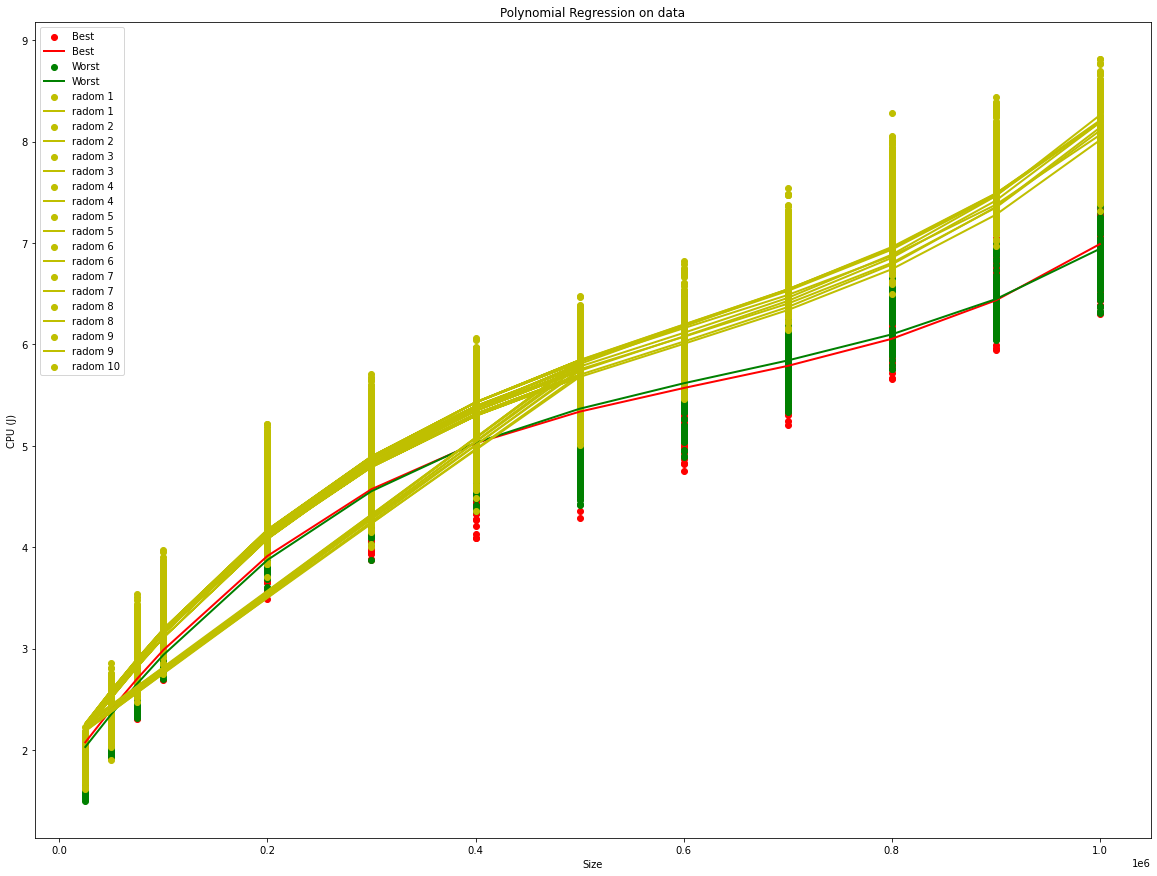

In [377]:
plt.figure(figsize=(20, 15))
polyReg(dfBest["Size"], dfBest["CPU (J)"], 4, "Best", "red", minDegrees=3, printR2Score=False)
polyReg(dfWorst["Size"], dfWorst["CPU (J)"], 4, "Worst", "green", minDegrees=3, printR2Score=False)

for i in range(1,11):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"], 4, f"radom {i}", "y", minDegrees=3, printR2Score=False, plotGraph=True)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('CPU (J)')
plt.show()

##### Size vs Time (ms)

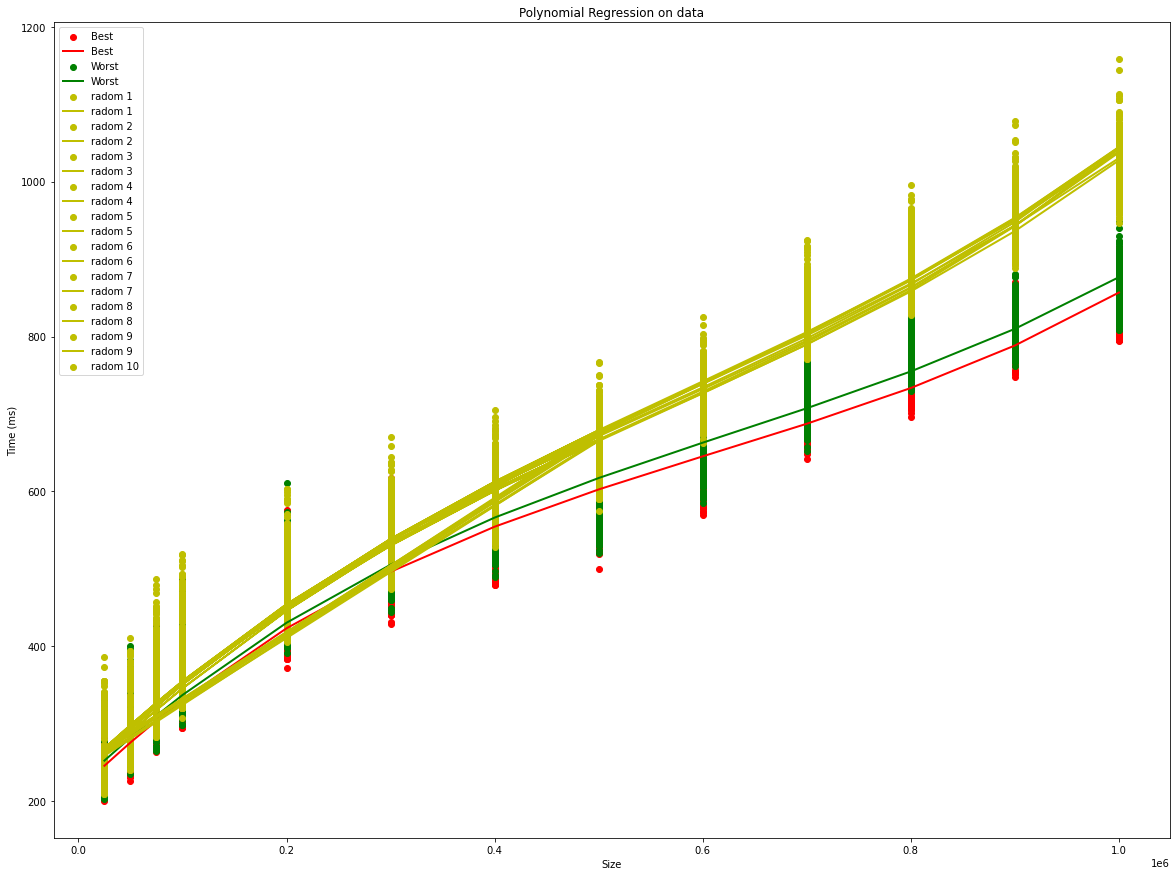

In [378]:
plt.figure(figsize=(20, 15))
polyReg(dfBest["Size"], dfBest["Time (ms)"], 4, "Best", "red", minDegrees=3, printR2Score=False)
polyReg(dfWorst["Size"], dfWorst["Time (ms)"], 4, "Worst", "green", minDegrees=3, printR2Score=False)

for i in range(1,11):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"], 4, f"radom {i}", "y", minDegrees=3, printR2Score=False, plotGraph=True)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('Time (ms)')
plt.show()

#### DTR of Size vs Memory comsumption

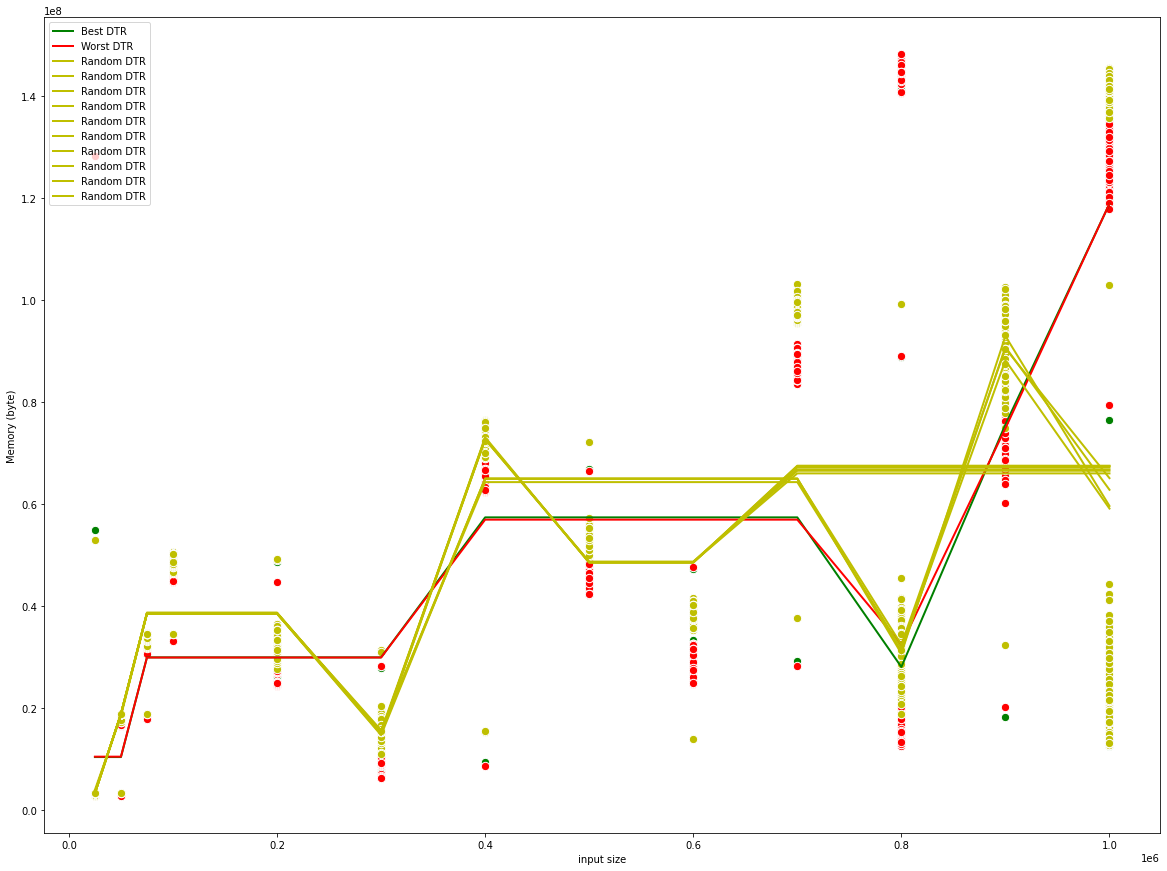

In [379]:
plt.figure(figsize=(20,15))
dtr(dfBest[["Size"]], dfBest["Memory (byte)"], "Best DTR", "green", plotGraph=True)
dtr(dfWorst[["Size"]], dfWorst["Memory (byte)"], "Worst DTR", "red", plotGraph=True)

for i in range (1,11):
    dtr(listOfRandoms[i][["Size"]], listOfRandoms[i]["Memory (byte)"], "Random DTR", "y", plotGraph=True)

plt.legend(loc='upper left')
plt.title("")
plt.xlabel("input size")
plt.ylabel('Memory (byte)')
plt.show()

#### DTR of Time (ms) vs Temperature

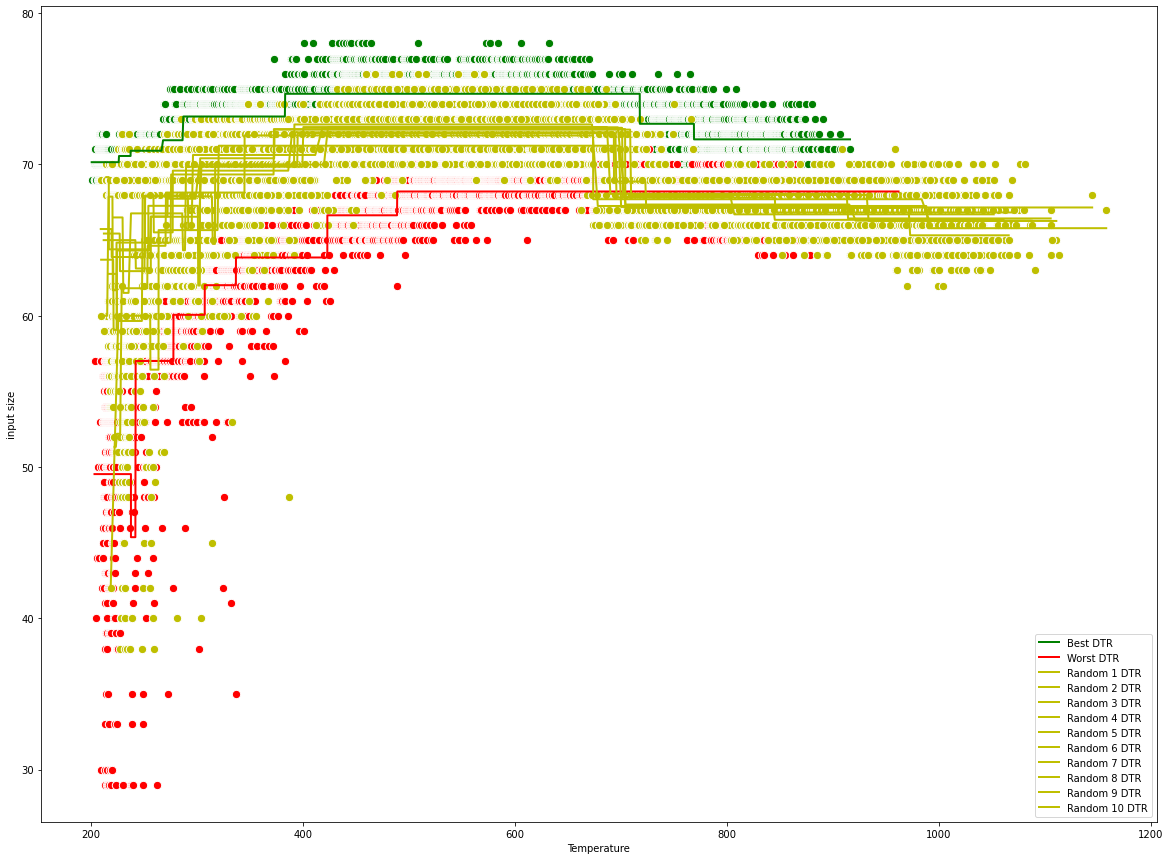

In [380]:
plt.figure(figsize=(20,15))
dtr(dfBest[["Time (ms)"]], dfBest["Temperature"], "Best DTR", "green", plotGraph=True, strX='Time (ms)')
dtr(dfWorst[["Time (ms)"]], dfWorst["Temperature"], "Worst DTR", "red", plotGraph=True, strX='Time (ms)')

for i in range (1,11):
    dtr(listOfRandoms[i][["Time (ms)"]], listOfRandoms[i]["Temperature"], f"Random {i} DTR", "y", plotGraph=True, strX='Time (ms)')

plt.legend(loc='lower right')
plt.title("")
plt.xlabel("Temperature")
plt.ylabel('input size')
plt.show()

## 5. Conclusion and Discussion

[Here you may draw your conclusion based on the previous sections, and discuss the pros and cons of the project, and propose something for future work.]

When looking at the data, both graphically and through the lenses of analytical number, such as $R^2$, absolute error, ect, the data can give a varying conclusion. Further more, it is important to consider how the data has been collected. 

In the case of the data displayed in this document, the data was collected by us. This data shows different aspects of resource consumption for when the algorithm `MergeSort` is running. The finalized data frame conained these columns:

df.columns = ``[Test Name, PKG (J), CPU (J), GPU (J), Memory (J),Temperature (``&deg;``C), Time (ms), Memory (byte), Size]``

Of this DataFrame, four features were chosen, namely ``CPU (J), Memory(byte), Time(ms) with respect to Size, and Temperature with respect to Time (ms)``. 

With these features a range of regressions were applied, where the $R^2$ value was compared between, firstly regression types, and secondly degree (in the case of polynomial regression). From this, the "best" regression type was chosen for a given feature, and if a feature had more than one "best" regression type between input types, the most frequent was chosen. 

The subset of the dataset containing the feature was then split up 80%/20% to have a training set(80%) and a testing set(20%), to evaluate the error of the model applied to the data. Finally the model was visually applied to the data, and graphed in section 4.4. 


Information gathered from each feature:
-   ``Time(ms), Size``: 
When looking at the time consumption of Mergesort over the input size, we see a gradual growth, much as expected. The abnormal results from the tests are the relations between worst case, best case, and random case input. Here, we expect the worst case (red) to be the slowest, the best case(green) to be the fastest, and random case (yellow) to be inbetween somewhere. But the data shows the random case as slower than the worst case, which sparks an interesting discussion of where this optimization is stemming from. 
Since the Mergesort algorithm was implemented in Java, which has many small fine adjustments in the comiler, such as the JIT (Just In Time compiler), the worst case might have been optimized. 
The evaluations average values of this feature: 
    -   Regression type: ``Polynomial 3dg``
    -   $R^2$ : $0.97619$
    -   Mean absolute error:  $27.61571$ 
    -   Mean squared error:  $1249.63896$
    -   Root mean squared error:  $35.26314$

<br />

-   ``Memory(byte), Size``:
This data is completely incompresenible. The data is all over the place and has only the DTR return a comprehensive $R^2$ value. This data was expected to show a gradual growth as the input size increases, but the data shows no graduality. Here the data could have been affected by the compiler of Java once more. Java has a garbage collector which will "clean" the stack of any unused or unreferenced data. This could be why we see the memory consumption shift so drastically between sizes. Further more, the discrepency could originate from the memory collection technique used. The memory is collected with the System class called Runtime, which contains the free memory in the JVM and the Total memory of the JVM. These two are subtracted from eachotehr to give the used memory. This could pose a problem if the memory of the JVM is not cleared when rerunning an algorithm  to get a new sample point. This could explain the arbitrarity of the data. When looking at the $R^2$ or any of the error calculations, we further see that this model is not representative of the data and that the datapoints seem to be scattered in a manner which cannot be regressed with DTR, linear regression, polynomial regression, or logistic regression. 
The evaluations average values of this feature:
    -   Regression type: ``DTR`` 
    -   $R^2$ : $0.63734$
    -   Mean absolute error:  $10534277$
    -   Mean squared error:  $338301718270122$
    -   Root mean squared error:  $18124568$

<br />

-   ``CPU (J), Size``:
Here, the model shows a gradual growth, like expected. Although like the ``Time(ms) vs input size`` feature, this feature also has the unexpected result of having the random case input be worse than the worst case input. Further more, it looks as if the model has not included some data points in its evaluation at size $50$k to $400$k. Here we se the model go in a straight line from the data point on $25$k to 500$k. While the data acting unexpected is unfortunate, the model of energy consumption does follows the model of time consumption to a high relation. These two models seems to follow the same tren of missing some data points in the earlier input sizes, having a $3$dg polynomial fit with an $R^2$ value of roughly $0.975$, and also follow the same shape. They also follow eachother in the tendency of having the best case input as the best, the worst case slightly worse and the random on top. 
The evaluations average values of this feature: 
    -   Regression type: ``Polynomial 3dg``
    -   $R^2$ : $0.97523$
    -   Mean absolute error:  $0.25064$
    -   Mean squared error:  $0.09751$
    -   Root mean squared error:  $0.31171$

<br />

-   ``Temperature, Time ``:
Finally, the temperature in relation to time model. This model is constructed to see how temperature of the CPU might increase as the computer executes more runs of mergesort. Here the order of which case input was first is highly relevant as the temperature of the system on start is lower than when switching between cases. Here we see that there are two input cases starting between $40$ and $50$ &deg;C, which is explained by the experimental setup. Here the test laptops are placed in a temperature controlled environment to ensure as little noise as posible. Although as the test ran, an error occured after runnning worst case input. This stopped the test and gave the laptops time to cool down before we noticed and could continue the experiemnt. Here we started the experiemnt on the random case input and due to time restrictions did not re-run the worst case input. Finally the best case input which rests between $70$ and $75$ &deg;C which does not have a starting point in $40$, since the test did not stop between random case input and best case input. While this inconsistency can be considered as bad, we choose to disregard the lower starting temperature since it rises to $70+$ &deg;C at a very high speed, where all the input cases rest for most of the samples. 
The evaluations average values of this feature: 
    -   Regression type: ``DTR``
    -   $R^2$ : $0.62319$
    -   Mean absolute error:  $2.56082$
    -   Mean squared error:  $20.00080$
    -   root mean squared error:  $4.31780$